In [ ]:
!pip install transformers
!pip install datasets
!pip install jiwer
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 8.6 MB/s 
     |████████████████████████████████| 7.6 MB 55.0 MB/s 
     |████████████████████████████████| 163 kB 69.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 6.7 MB/s 
     |████████████████████████████████| 95 kB 5.5 MB/s 
     |████████████████████████████████| 115 kB 75.4 MB/s 
     |████████████████████████████████| 212 kB 67.3 MB/s 
     |████████████████████████████████| 127 kB 57.9 MB/s 
     |████████████████████████████████| 115 kB 69.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully unin

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
import pandas as pd 

global_path =  '../../'
train_path = global_path + 'data/interim/train.csv'
val_path = global_path + 'data/interim/val.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(val_path)

# train_df = train_df[:5000]
# test_df = test_df[:500]

FileNotFoundError: [Errno 2] No such file or directory: '../../data/interim/train.csv'

In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df,feature_extractor,tokenizer, max_target_length=512):
        self.root_dir = root_dir
        self.df = df
        # self.processor = processor #feature_extractor
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = str(self.df['filmId'][idx]) + '.jpg'
        text = self.df['description'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        image = image.resize([224, 224])
        pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
       
        labels = self.tokenizer(text, 
                                          truncation='longest_first',
                                          padding="max_length", 
                                          # return_tensors="pt",
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import ViTFeatureExtractor, BertTokenizer, VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-224-in21k", "DeepPavlov/rubert-base-cased"
)

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

for param in model.encoder.parameters():
    param.requires_grad = False

train_dataset = IAMDataset(root_dir=global_path + 'data/img/',
                           df=train_df,
                           feature_extractor=feature_extractor,
                           tokenizer=tokenizer
                           )
eval_dataset = IAMDataset(root_dir=global_path + 'data/img/',
                           df=test_df,
                           feature_extractor=feature_extractor,
                           tokenizer=tokenizer
                          )

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['bert.encoder.layer.5.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.7.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.11.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattent

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 23556
Number of validation examples: 2945


In [ ]:
from transformers import VisionEncoderDecoderModel

for param in model.base_model.encoder.parameters():
      param.requires_grad = False
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    # num_train_epochs=3,
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=500,
    eval_steps=500,
)

In [ ]:
from datasets import load_metric

metric = load_metric('sacrebleu')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    bleu = metric.compute(predictions=[pred_str], references=[label_str])

    return {"bleu": bleu}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 23556
  Num Epochs = 3
  Instantaneous batch size per device = 6
  Total train batch size (w. parallel, distributed & accumulation) = 6
  Gradient Accumulation steps = 1
  Total optimization steps = 11778
  Number of trainable parameters = 206341371


Step,Training Loss,Validation Loss,Bleu
500,5.226700,4.921919,"{'score': 0.9009776641366343, 'counts': [1225, 1611, 1100, 452], 'totals': [110467, 110466, 110465, 110464], 'precisions': [1.1089284582726062, 1.4583672804301777, 0.9957905218847599, 0.40918308227114714], 'bp': 1.0, 'sys_len': 110467, 'ref_len': 304}"
1000,5.001600,4.769070,"{'score': 0.7719662163625992, 'counts': [953, 1207, 808, 356], 'totals': [98248, 98247, 98246, 98245], 'precisions': [0.9699943001384252, 1.2285362402923246, 0.8224253404718768, 0.3623594076034404], 'bp': 1.0, 'sys_len': 98248, 'ref_len': 304}"
1500,4.785100,4.677254,"{'score': 0.8377344812847479, 'counts': [1063, 1338, 900, 375], 'totals': [99361, 99360, 99359, 99358], 'precisions': [1.0698362536608932, 1.3466183574879227, 0.9058062178564599, 0.37742305601964615], 'bp': 1.0, 'sys_len': 99361, 'ref_len': 304}"
2000,4.715600,4.610808,"{'score': 0.7802465339507894, 'counts': [1084, 1330, 861, 367], 'totals': [105296, 105295, 105294, 105293], 'precisions': [1.0294788026135846, 1.263117906833183, 0.817710410849621, 0.34855118573884303], 'bp': 1.0, 'sys_len': 105296, 'ref_len': 304}"
2500,4.831200,4.561728,"{'score': 1.1744936954975425, 'counts': [1619, 2356, 1731, 743], 'totals': [126716, 126715, 126714, 126713], 'precisions': [1.2776602796805454, 1.859290533875232, 1.3660684691510014, 0.5863644614206909], 'bp': 1.0, 'sys_len': 126716, 'ref_len': 304}"
3000,4.691600,4.509811,"{'score': 0.7351235212162127, 'counts': [930, 1093, 695, 281], 'totals': [90802, 90801, 90800, 90799], 'precisions': [1.024206515274994, 1.2037312364401274, 0.7654185022026432, 0.30947477395125494], 'bp': 1.0, 'sys_len': 90802, 'ref_len': 304}"
3500,4.620700,4.477849,"{'score': 0.6178602537921638, 'counts': [808, 854, 498, 172], 'totals': [79804, 79803, 79802, 79801], 'precisions': [1.012480577414666, 1.0701352079495758, 0.6240445101626526, 0.2155361461635819], 'bp': 1.0, 'sys_len': 79804, 'ref_len': 304}"
4000,4.241300,4.457824,"{'score': 1.055131290329724, 'counts': [1519, 1861, 1165, 487], 'totals': [106657, 106656, 106655, 106654], 'precisions': [1.424191567360792, 1.7448619861986199, 1.0923069710749613, 0.45661672323588426], 'bp': 1.0, 'sys_len': 106657, 'ref_len': 304}"
4500,3.982300,4.451946,"{'score': 1.0157414391841781, 'counts': [1402, 1838, 1193, 490], 'totals': [109070, 109069, 109068, 109067], 'precisions': [1.285413037498854, 1.6851717719975428, 1.0938130340704881, 0.44926513060779155], 'bp': 1.0, 'sys_len': 109070, 'ref_len': 304}"
5000,3.913700,4.435126,"{'score': 1.6583436761216357, 'counts': [1895, 2588, 1687, 747], 'totals': [95079, 95078, 95077, 95076], 'precisions': [1.993079439203189, 2.7219756410526093, 1.774351315249745, 0.7856872396819387], 'bp': 1.0, 'sys_len': 95079, 'ref_len': 304}"


***** Running Evaluation *****
  Num examples = 2945
  Batch size = 6
Trainer is attempting to log a value of "{'score': 0.9009776641366343, 'counts': [1225, 1611, 1100, 452], 'totals': [110467, 110466, 110465, 110464], 'precisions': [1.1089284582726062, 1.4583672804301777, 0.9957905218847599, 0.40918308227114714], 'bp': 1.0, 'sys_len': 110467, 'ref_len': 304}" of type <class 'dict'> for key "eval/bleu" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
Feature extractor saved in ./checkpoint-500/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2945
  Batch size = 6
Trainer is attempting to log a value of "{'score': 0.7719662163625992, 'counts': [953, 1207, 808, 356], 'totals': [98248, 98247, 98246, 98245], 'precisions': [0.9699943001384252, 1.2285362402

In [ ]:
max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

images = []
image_path = global_path + 'data/img/299.jpg';
i_image = Image.open(image_path)
i_image = i_image.resize([224,224])
if i_image.mode != "RGB":
  i_image = i_image.convert(mode="RGB")

# model.feat
images.append(i_image)
pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
pixel_values = pixel_values.to(device)

output_ids = model.generate(pixel_values, **gen_kwargs)

preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
preds = [pred.strip() for pred in preds]
preds

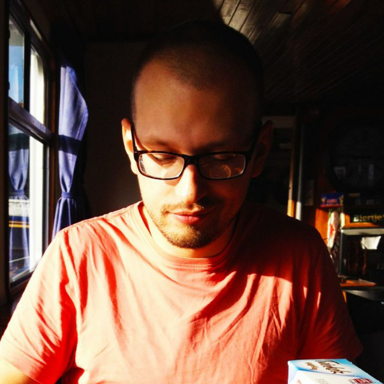

In [ ]:
i_image

In [ ]:
trainer.save_model(global_path + 'model_ru')

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/mpc/movie_posters_captioning/model_ru
Configuration saved in /content/drive/MyDrive/Colab Notebooks/mpc/movie_posters_captioning/model_ru/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/mpc/movie_posters_captioning/model_ru/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/Colab Notebooks/mpc/movie_posters_captioning/model_ru/preprocessor_config.json


In [ ]:
# import gc
# del x
# gc.collect()
# torch.cuda.empty_cache()